In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disco2025/dataset_edit.csv


In [2]:
pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.9 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import library yang diperlukan
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
# Load dataset
df = pd.read_csv('/kaggle/input/disco2025/dataset_edit.csv')

# Preprocesing

In [5]:
# 1. Hapus baris dengan id_umkm kosong
df = df.dropna(subset=['id_umkm'])

# 2. Hapus duplikat berdasarkan id_umkm
df = df.drop_duplicates(subset=['id_umkm'])

# 3. Konversi kolom numerik dari string ke float
numeric_cols = [
    'tenaga_kerja_perempuan', 'tenaga_kerja_laki_laki', 'aset', 'omset',
    'kapasitas_produksi', 'tahun_berdiri', 'laba', 'biaya_karyawan', 'jumlah_pelanggan'
]

for col in numeric_cols:
    # Coba konversi ke float, jika error set sebagai NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')


# 4. Penanganan missing values untuk kolom kategorikal
categorical_cols = ['jenis_usaha', 'marketplace', 'status_legalitas']

In [6]:
# Definisi kolom
numerical_cols = ['aset', 'omset', 'laba', 'biaya_karyawan', 'tahun_berdiri', 'kapasitas_produksi', 'jumlah_pelanggan']
categorical_cols = ['jenis_usaha', 'status_legalitas']

# Feature Engineering - Klasifikasi UMKM
KRITERIA_MIKRO_ASET = 50000000
KRITERIA_MIKRO_OMSET = 300000000
KRITERIA_KECIL_ASET = 500000000
KRITERIA_KECIL_OMSET = 2500000000
KRITERIA_MENENGAH_ASET = 10000000000
KRITERIA_MENENGAH_OMSET = 50000000000

def klasifikasi_umkm(row):
    try:
        aset = float(row['aset'])
        omset = float(row['omset'])
    except (ValueError, TypeError):
        return 'Tidak Terdefinisi'
    
    if (aset <= KRITERIA_MIKRO_ASET) or (omset <= KRITERIA_MIKRO_OMSET):
        return 'Mikro'
    elif (aset <= KRITERIA_KECIL_ASET) or (omset <= KRITERIA_KECIL_OMSET):
        return 'Kecil'
    elif (aset <= KRITERIA_MENENGAH_ASET) or (omset <= KRITERIA_MENENGAH_OMSET):
        return 'Menengah'
    else:
        return 'Lainnya (Besar)'

# Tambahkan kolom kategori_umkm ke DataFrame asli (df)
df['kategori_umkm'] = df.apply(klasifikasi_umkm, axis=1)

# Update categorical_cols setelah fitur baru ditambahkan
categorical_cols = ['jenis_usaha', 'status_legalitas', 'kategori_umkm']

# Buat data input X
X = df[numerical_cols + categorical_cols]

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Transformasi fitur
X_preprocessed = preprocessor.fit_transform(X)

# Cek hasil klasifikasi UMKM
print("\nDistribusi Kategori UMKM:")
print(df['kategori_umkm'].value_counts())

# Contoh hasil klasifikasi
print("\nContoh hasil klasifikasi:")
print(df[['id_umkm', 'nama_usaha', 'aset', 'omset', 'kategori_umkm']].head(50))


Distribusi Kategori UMKM:
kategori_umkm
Mikro    13439
Name: count, dtype: int64

Contoh hasil klasifikasi:
     id_umkm                   nama_usaha       aset       omset kategori_umkm
0   28828567           UD. Alif Pamungkas  5497149.0   3347794.0         Mikro
1   28828568            UD. Zidanar Panji  7398384.0  39969661.0         Mikro
2   28828569        UD. Winda Jayengprana  8881762.0  25253355.0         Mikro
3   28828570           UD. Damaris Satria  9576178.0  20700389.0         Mikro
4   28828571           UD. Qasya Wiratama  9456853.0   4820810.0         Mikro
5   28828572    UD. Grego Wiraatmaja Nara  9072119.0  19297316.0         Mikro
6   28828573           UD. Mika Bagaskara  8132674.0   4699257.0         Mikro
7   28828574             UD. Yora Selaras  7072036.0  16709414.0         Mikro
8   28828575             UD. Wenny Langit  2745878.0         NaN         Mikro
9   28828576              UD. Fani Wijaya  8136758.0  42552398.0         Mikro
10  28828577         U

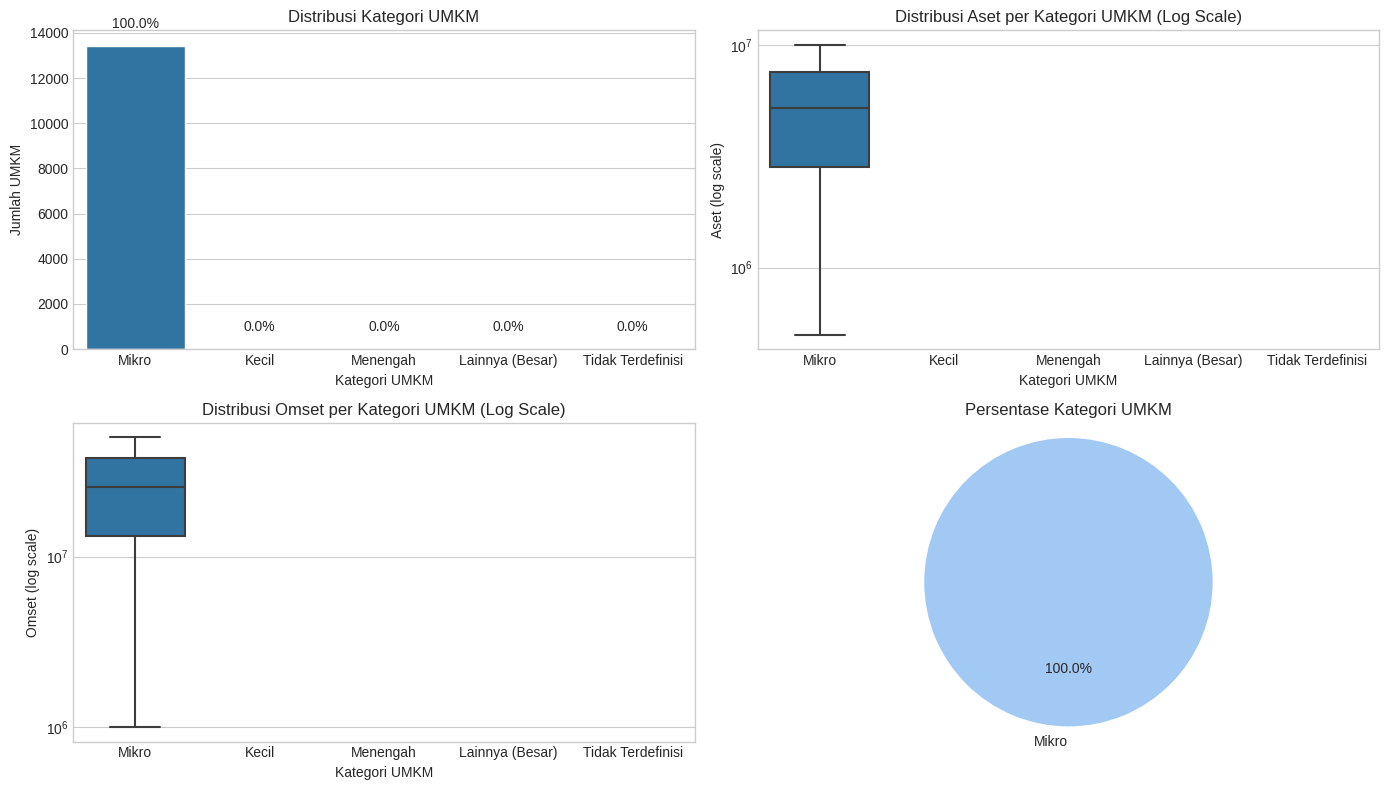


Tabel Ringkasan Kategori UMKM:
  kategori_umkm  jumlah proporsi  aset_median     aset_mean  omset_median  \
0         Mikro   13439   100.0%    5211609.0  5.223773e+06    25658131.0   

     omset_mean  
0  2.556848e+07  


In [7]:
# Visualisasi Hasil Kategori UMKM
# Setting gaya plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# Plot 1: Distribusi Kategori UMKM (Countplot)
plt.subplot(2, 2, 1)
ax = sns.countplot(x='kategori_umkm', data=df, order=['Mikro', 'Kecil', 'Menengah', 'Lainnya (Besar)', 'Tidak Terdefinisi'])
plt.title('Distribusi Kategori UMKM')
plt.xlabel('Kategori UMKM')
plt.ylabel('Jumlah UMKM')

# Tambahkan label persentase
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%\n'
    height = p.get_height()
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot 2: Distribusi Aset per Kategori (Boxplot)
plt.subplot(2, 2, 2)
sns.boxplot(x='kategori_umkm', y='aset', data=df, 
            order=['Mikro', 'Kecil', 'Menengah', 'Lainnya (Besar)', 'Tidak Terdefinisi'],
            showfliers=False)  # Sembunyikan outlier untuk visualisasi lebih baik
plt.yscale('log')  # Skala logaritmik karena rentang nilai besar
plt.title('Distribusi Aset per Kategori UMKM (Log Scale)')
plt.xlabel('Kategori UMKM')
plt.ylabel('Aset (log scale)')

# Plot 3: Distribusi Omset per Kategori (Boxplot)
plt.subplot(2, 2, 3)
sns.boxplot(x='kategori_umkm', y='omset', data=df, 
            order=['Mikro', 'Kecil', 'Menengah', 'Lainnya (Besar)', 'Tidak Terdefinisi'],
            showfliers=False)  # Sembunyikan outlier
plt.yscale('log')  # Skala logaritmik
plt.title('Distribusi Omset per Kategori UMKM (Log Scale)')
plt.xlabel('Kategori UMKM')
plt.ylabel('Omset (log scale)')

# Plot 4: Pie Chart Persentase Kategori
plt.subplot(2, 2, 4)
kategori_counts = df['kategori_umkm'].value_counts()
plt.pie(kategori_counts, labels=kategori_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('pastel'))
plt.title('Persentase Kategori UMKM')
plt.axis('equal')  # Pastikan pie chart lingkaran sempurna

plt.tight_layout()
plt.savefig('distribusi_umkm.png', dpi=300)
plt.show()

# Analisis Tambahan: Tabel Ringkasan
ringkasan = df.groupby('kategori_umkm').agg(
    jumlah=('id_umkm', 'count'),
    proporsi=('id_umkm', lambda x: f"{len(x)/total*100:.1f}%"),
    aset_median=('aset', 'median'),
    aset_mean=('aset', 'mean'),
    omset_median=('omset', 'median'),
    omset_mean=('omset', 'mean')
).reset_index()

print("\nTabel Ringkasan Kategori UMKM:")
print(ringkasan)

# K optimal

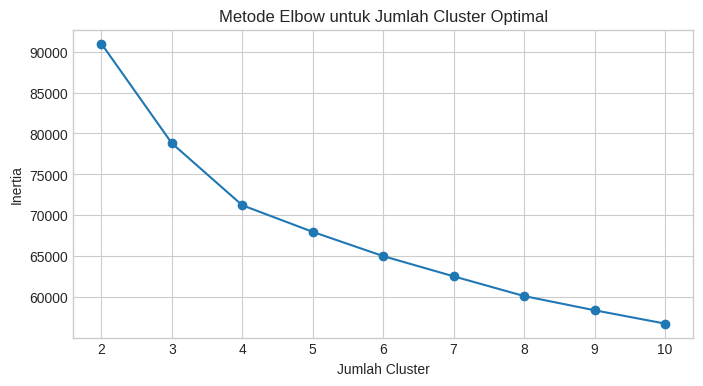

In [8]:
# Tentukan jumlah cluster optimal menggunakan Metode Elbow
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_preprocessed)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Jumlah Cluster Optimal')
plt.show()

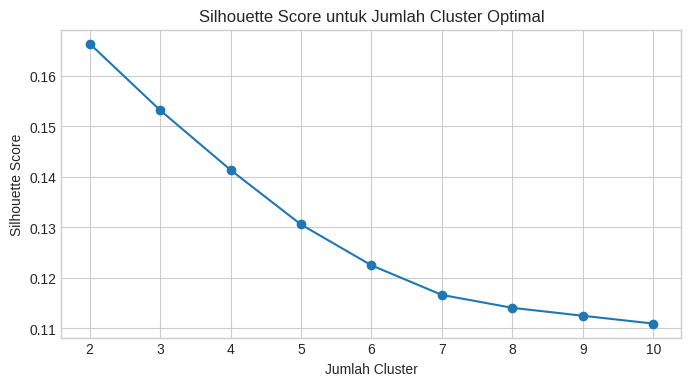

In [9]:
# Tentukan jumlah cluster optimal menggunakan Silhouette Score
silhouette_avg = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_preprocessed)
    silhouette_avg.append(silhouette_score(X_preprocessed, clusters))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_avg, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Jumlah Cluster Optimal')
plt.show()

# Clustering

In [10]:
# Pilih jumlah cluster optimal 
optimal_k = 2

# Lakukan clustering dengan K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_preprocessed)

# Tambahkan label cluster ke dataframe asli
df['cluster'] = clusters

In [11]:
# Interpretasi cluster
# Rata-rata variabel numerik per cluster
print("Rata-rata variabel numerik per cluster:")
print(df.groupby('cluster')[numerical_cols].mean())

# Distribusi variabel kategorikal per cluster
print("\nDistribusi variabel kategorikal per cluster:")
for col in categorical_cols:
    print(f"\nDistribusi {col} per cluster:")
    print(df.groupby(['cluster', col]).size().unstack(fill_value=0))

Rata-rata variabel numerik per cluster:
                 aset         omset          laba  biaya_karyawan  \
cluster                                                             
0        5.228466e+06  2.551621e+07  2.028269e+07    2.975181e+08   
1        5.219080e+06  2.562064e+07  2.041299e+07    2.956083e+08   

         tahun_berdiri  kapasitas_produksi  jumlah_pelanggan  
cluster                                                       
0          2012.097260          251.732900        252.184750  
1          2011.926076          746.976398        746.670475  

Distribusi variabel kategorikal per cluster:

Distribusi jenis_usaha per cluster:
jenis_usaha  Fashion  Jasa  Kesehatan  Makanan & Minuman  Pendidikan  \
cluster                                                                
0                 14  1702       1623                 14        1608   
1                 12  1670       1613                 17        1620   

jenis_usaha  Perdagangan  Perusahaan  unknown  
cluster    

# Interpretasi

1. Kapasitas Produksi

Cluster 0 memiliki kapasitas produksi yang rendah, yaitu rata-rata sebesar 251,73, sedangkan Cluster 1 memiliki kapasitas produksi yang tinggi dengan rata-rata sebesar 746,98. Hal ini mengimplikasikan bahwa risiko kredit cenderung tinggi untuk pelaku usaha di Cluster 0 dan lebih rendah untuk Cluster 1.

2. . Jumlah Pelanggan

Cluster 0 juga memiliki jumlah pelanggan yang rendah, yakni sekitar 252,18, sementara Cluster 1 memiliki jumlah pelanggan yang jauh lebih tinggi, yaitu 746,67. Ini menunjukkan bahwa risiko kredit pada Cluster 0 lebih tinggi dibandingkan dengan Cluster 1.

3. . Aset, Omset, dan Laba

Rata-rata nilai aset, omset, dan laba pada kedua cluster relatif mirip, sehingga tidak terdapat perbedaan signifikan antara Cluster 0 dan Cluster 1 dalam aspek ini. Oleh karena itu, aspek ini tidak menjadi pembeda utama dalam risiko kredit.

4. Status Legalitas

Persentase pelaku usaha yang terdaftar secara legal hampir sama pada kedua cluster, yaitu sekitar 51% di Cluster 0 dan 51,5% di Cluster 1. Dengan demikian, tidak terdapat perbedaan signifikan dalam status legalitas antar cluster.

5. Kategori UMKM

Mayoritas pelaku usaha pada kedua cluster termasuk dalam kategori mikro, dengan jumlah yang hampir sama (6707 di Cluster 0 dan 6732 di Cluster 1). Ini menunjukkan bahwa kategori UMKM juga tidak menjadi faktor pembeda yang signifikan dalam segmentasi risiko kredit.

# Pemodelan Akhir

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [13]:
df = pd.read_csv('/kaggle/input/disco2025/dataset_edit.csv')

In [14]:
def preprocess_data(df):
    # Hapus baris dengan id_umkm kosong
    df = df.dropna(subset=['id_umkm'])
    df = df.drop_duplicates(subset=['id_umkm'])
    
    # Konversi kolom numerik
    numeric_cols = [
        'tenaga_kerja_perempuan', 'tenaga_kerja_laki_laki', 'aset', 'omset',
        'kapasitas_produksi', 'tahun_berdiri', 'laba', 'biaya_karyawan', 'jumlah_pelanggan'
    ]
    
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Feature Engineering - Klasifikasi UMKM
    KRITERIA_MIKRO_ASET = 50000000
    KRITERIA_MIKRO_OMSET = 300000000
    KRITERIA_KECIL_ASET = 500000000
    KRITERIA_KECIL_OMSET = 2500000000
    KRITERIA_MENENGAH_ASET = 10000000000
    KRITERIA_MENENGAH_OMSET = 50000000000
    
    def klasifikasi_umkm(row):
        try:
            aset = float(row['aset'])
            omset = float(row['omset'])
        except (ValueError, TypeError):
            return 'Tidak Terdefinisi'
        
        if (aset <= KRITERIA_MIKRO_ASET) or (omset <= KRITERIA_MIKRO_OMSET):
            return 'Mikro'
        elif (aset <= KRITERIA_KECIL_ASET) or (omset <= KRITERIA_KECIL_OMSET):
            return 'Kecil'
        elif (aset <= KRITERIA_MENENGAH_ASET) or (omset <= KRITERIA_MENENGAH_OMSET):
            return 'Menengah'
        else:
            return 'Lainnya (Besar)'
    
    df['kategori_umkm'] = df.apply(klasifikasi_umkm, axis=1)
    
    # Definisi kolom untuk clustering
    numerical_cols = ['aset', 'omset', 'laba', 'biaya_karyawan', 'tahun_berdiri', 
                     'kapasitas_produksi', 'jumlah_pelanggan']
    categorical_cols = ['jenis_usaha', 'status_legalitas', 'kategori_umkm']
    
    # Buat preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    X = df[numerical_cols + categorical_cols]
    X_preprocessed = preprocessor.fit_transform(X)
    
    return df, X_preprocessed, numerical_cols, categorical_cols, preprocessor

In [27]:
df_preprocessed = pd.DataFrame(X_preprocessed)

# Lihat beberapa baris awal
print(df_preprocessed.head(10))

         0         1         2         3         4         5         6    7   \
0  0.100453 -1.572516 -1.561853 -1.027093  0.413439 -0.073655 -0.073098  0.0   
1  0.798743  1.019035  0.848348 -1.223406  0.275101 -0.126494 -0.125966  0.0   
2  1.343562 -0.022366 -0.276185  0.641566 -1.661631 -0.411827 -0.411453  0.0   
3  1.598608 -0.344558 -0.640443 -0.119146 -1.246617  1.712316  1.713842  0.0   
4  1.554783 -1.468278 -1.734472  1.255044 -1.384955 -0.654888 -0.654646  0.0   
5  1.413477 -0.443846 -0.702850  0.322558 -1.661631  0.567463  0.568368  0.0   
6  1.068435 -1.476879 -1.650989 -0.217302 -1.246617  0.754162  0.004442  0.0   
7  0.678882 -0.626979 -0.743654 -0.511772 -0.416589 -0.140585 -0.140064  0.0   
8 -0.910040  0.006278  1.301864  1.598591 -1.661631 -1.338277 -1.338406  0.0   
9  1.069935  1.201802  0.976378 -0.879858 -0.831603  1.307214  1.308520  0.0   

    8    9    10   11   12   13   14   15   16   17   18  
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  
1

In [15]:
def evaluate_clustering(X, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return {
            'silhouette_score': -1,
            'calinski_harabasz_score': 0,
            'davies_bouldin_score': float('inf'),
            'n_clusters': len(unique_labels)
        }
    
    try:
        silhouette = silhouette_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        
        return {
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski_harabasz,
            'davies_bouldin_score': davies_bouldin,
            'n_clusters': len(unique_labels)
        }
    except:
        return {
            'silhouette_score': -1,
            'calinski_harabasz_score': 0,
            'davies_bouldin_score': float('inf'),
            'n_clusters': len(unique_labels)
        }

In [16]:
def compare_clustering_algorithms(X_preprocessed, df, numerical_cols, categorical_cols):
    results = {}
    cluster_labels = {}
    
    # 1. K-Means Clustering
    print("1. K-Means Clustering")
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_preprocessed)
    results['K-Means'] = evaluate_clustering(X_preprocessed, kmeans_labels)
    cluster_labels['K-Means'] = kmeans_labels
    print(f"   Clusters: {results['K-Means']['n_clusters']}")
    print(f"   Silhouette Score: {results['K-Means']['silhouette_score']:.4f}")
    print(f"   Calinski-Harabasz Score: {results['K-Means']['calinski_harabasz_score']:.4f}")
    print(f"   Davies-Bouldin Score: {results['K-Means']['davies_bouldin_score']:.4f}\n")
    
    # 2. Hierarchical Clustering (Agglomerative)
    print("2. Hierarchical Clustering (Agglomerative)")
    hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward')
    hierarchical_labels = hierarchical.fit_predict(X_preprocessed)
    results['Hierarchical'] = evaluate_clustering(X_preprocessed, hierarchical_labels)
    cluster_labels['Hierarchical'] = hierarchical_labels
    print(f"   Clusters: {results['Hierarchical']['n_clusters']}")
    print(f"   Silhouette Score: {results['Hierarchical']['silhouette_score']:.4f}")
    print(f"   Calinski-Harabasz Score: {results['Hierarchical']['calinski_harabasz_score']:.4f}")
    print(f"   Davies-Bouldin Score: {results['Hierarchical']['davies_bouldin_score']:.4f}\n")
    
    # 3. DBSCAN
    print("3. DBSCAN")
    dbscan = DBSCAN(eps=1.5, min_samples=50)
    dbscan_labels = dbscan.fit_predict(X_preprocessed)
    results['DBSCAN'] = evaluate_clustering(X_preprocessed, dbscan_labels)
    cluster_labels['DBSCAN'] = dbscan_labels
    print(f"   Clusters: {results['DBSCAN']['n_clusters']} (excluding noise)")
    print(f"   Noise points: {np.sum(dbscan_labels == -1)}")
    print(f"   Silhouette Score: {results['DBSCAN']['silhouette_score']:.4f}")
    print(f"   Calinski-Harabasz Score: {results['DBSCAN']['calinski_harabasz_score']:.4f}")
    print(f"   Davies-Bouldin Score: {results['DBSCAN']['davies_bouldin_score']:.4f}\n")
    
    # 4. Gaussian Mixture Model
    print("4. Gaussian Mixture Model")
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm_labels = gmm.fit_predict(X_preprocessed)
    results['GMM'] = evaluate_clustering(X_preprocessed, gmm_labels)
    cluster_labels['GMM'] = gmm_labels
    print(f"   Clusters: {results['GMM']['n_clusters']}")
    print(f"   Silhouette Score: {results['GMM']['silhouette_score']:.4f}")
    print(f"   Calinski-Harabasz Score: {results['GMM']['calinski_harabasz_score']:.4f}")
    print(f"   Davies-Bouldin Score: {results['GMM']['davies_bouldin_score']:.4f}\n")
    
    # Untuk evaluasi full dataset, kita gunakan KMeans pada hasil PCA
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X_preprocessed)
    spectral_full = SpectralClustering(n_clusters=3, random_state=42, affinity='rbf')
    spectral_labels = spectral_full.fit_predict(X_pca)
    
    results['Spectral'] = evaluate_clustering(X_preprocessed, spectral_labels)
    cluster_labels['Spectral'] = spectral_labels
    print(f"   Clusters: {results['Spectral']['n_clusters']}")
    print(f"   Silhouette Score: {results['Spectral']['silhouette_score']:.4f}")
    print(f"   Calinski-Harabasz Score: {results['Spectral']['calinski_harabasz_score']:.4f}")
    print(f"   Davies-Bouldin Score: {results['Spectral']['davies_bouldin_score']:.4f}\n")
    
    return results, cluster_labels

In [17]:
def visualize_comparison_results(results, cluster_labels, df, X_preprocessed, numerical_cols):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Comparison of Evaluation Metrics
    algorithms = list(results.keys())
    silhouette_scores = [results[alg]['silhouette_score'] for alg in algorithms]
    calinski_scores = [results[alg]['calinski_harabasz_score'] for alg in algorithms]
    davies_bouldin_scores = [results[alg]['davies_bouldin_score'] for alg in algorithms]
    
    # Plot 1: Silhouette Score
    axes[0, 0].bar(algorithms, silhouette_scores, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Silhouette Score Comparison\n(Higher is Better)')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(silhouette_scores):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Plot 2: Calinski-Harabasz Score
    axes[0, 1].bar(algorithms, calinski_scores, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Calinski-Harabasz Score Comparison\n(Higher is Better)')
    axes[0, 1].set_ylabel('Calinski-Harabasz Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(calinski_scores):
        axes[0, 1].text(i, v + max(calinski_scores)*0.02, f'{v:.0f}', ha='center', va='bottom')
    
    # Plot 3: Davies-Bouldin Score
    valid_db_scores = [score for score in davies_bouldin_scores if score != float('inf')]
    valid_algorithms = [alg for alg, score in zip(algorithms, davies_bouldin_scores) if score != float('inf')]
    
    axes[0, 2].bar(valid_algorithms, valid_db_scores, color='lightcoral', alpha=0.7)
    axes[0, 2].set_title('Davies-Bouldin Score Comparison\n(Lower is Better)')
    axes[0, 2].set_ylabel('Davies-Bouldin Score')
    axes[0, 2].tick_params(axis='x', rotation=45)
    for i, v in enumerate(valid_db_scores):
        axes[0, 2].text(i, v + max(valid_db_scores)*0.02, f'{v:.3f}', ha='center', va='bottom')
    
    # Plot 4-6: PCA visualization for different algorithms
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_preprocessed)
    
    plot_idx = 3
    for i, (alg_name, labels) in enumerate(list(cluster_labels.items())[:3]):
        row = (plot_idx + i) // 3
        col = (plot_idx + i) % 3
        
        scatter = axes[row, col].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6, s=1)
        axes[row, col].set_title(f'{alg_name} Clustering Results\n(PCA Visualization)')
        axes[row, col].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[row, col].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.colorbar(scatter, ax=axes[row, col])
    
    plt.tight_layout()
    plt.show()

In [18]:
def analyze_clusters_detailed(df, cluster_labels, numerical_cols, categorical_cols):
    for alg_name, labels in cluster_labels.items():
        print(f"--- {alg_name.upper()} CLUSTERING ---")
        
        # Tambahkan label cluster ke dataframe sementara
        df_temp = df.copy()
        df_temp['cluster'] = labels
        
        # Distribusi cluster
        cluster_dist = df_temp['cluster'].value_counts().sort_index()
        print(f"Distribusi Cluster:")
        for cluster_id, count in cluster_dist.items():
            percentage = (count / len(df_temp)) * 100
            print(f"  Cluster {cluster_id}: {count} ({percentage:.1f}%)")
        
        # Analisis variabel numerik
        print(f"\nRata-rata Variabel Numerik per Cluster:")
        numeric_analysis = df_temp.groupby('cluster')[numerical_cols].mean()
        print(numeric_analysis.round(2))
        
        # Analisis variabel kategorikal
        print(f"\nDistribusi Variabel Kategorikal per Cluster:")
        for col in categorical_cols:
            print(f"\n{col}:")
            cat_analysis = df_temp.groupby(['cluster', col]).size().unstack(fill_value=0)
            # Hitung persentase dalam setiap cluster
            cat_percentage = cat_analysis.div(cat_analysis.sum(axis=1), axis=0) * 100
            print(cat_percentage.round(1))
        
        print("\n" + "="*80 + "\n")

In [19]:
def generate_recommendations(results):
    # Buat ranking berdasarkan setiap metrik
    algorithms = list(results.keys())
    
    # Silhouette Score (higher is better)
    silhouette_ranking = sorted(algorithms, 
                               key=lambda x: results[x]['silhouette_score'], 
                               reverse=True)
    
    # Calinski-Harabasz Score (higher is better)
    calinski_ranking = sorted(algorithms, 
                             key=lambda x: results[x]['calinski_harabasz_score'], 
                             reverse=True)
    
    # Davies-Bouldin Score (lower is better)
    davies_bouldin_ranking = sorted([alg for alg in algorithms 
                                   if results[alg]['davies_bouldin_score'] != float('inf')], 
                                  key=lambda x: results[x]['davies_bouldin_score'])
    
    print("Ranking Algoritma berdasarkan Metrik Evaluasi:")
    print(f"1. Silhouette Score: {' > '.join(silhouette_ranking)}")
    print(f"2. Calinski-Harabasz Score: {' > '.join(calinski_ranking)}")
    print(f"3. Davies-Bouldin Score: {' > '.join(davies_bouldin_ranking)}")
    
    # Hitung composite score
    composite_scores = {}
    for alg in algorithms:
        score = 0
        # Silhouette score weight: 40%
        if results[alg]['silhouette_score'] > -1:
            score += 0.4 * (silhouette_ranking.index(alg) / len(silhouette_ranking))
        
        # Calinski-Harabasz score weight: 40%
        score += 0.4 * (calinski_ranking.index(alg) / len(calinski_ranking))
        
        # Davies-Bouldin score weight: 20%
        if alg in davies_bouldin_ranking:
            score += 0.2 * (davies_bouldin_ranking.index(alg) / len(davies_bouldin_ranking))
        
        composite_scores[alg] = score
    
    final_ranking = sorted(algorithms, key=lambda x: composite_scores[x])
    
    print(f"\nRanking Final (Composite Score): {' > '.join(final_ranking)}")
    
    print(f"ALGORITMA TERBAIK: {final_ranking[0]}")
    print(f"   - Silhouette Score: {results[final_ranking[0]]['silhouette_score']:.4f}")
    print(f"   - Calinski-Harabasz Score: {results[final_ranking[0]]['calinski_harabasz_score']:.4f}")
    print(f"   - Davies-Bouldin Score: {results[final_ranking[0]]['davies_bouldin_score']:.4f}")
    
    return final_ranking[0]

In [20]:
def main_clustering_analysis(df):
    
    # Preprocessing
    df_processed, X_preprocessed, numerical_cols, categorical_cols, preprocessor = preprocess_data(df)
    
    # Perbandingan algoritma clustering
    results, cluster_labels = compare_clustering_algorithms(X_preprocessed, df_processed, 
                                                          numerical_cols, categorical_cols)
    
    # Visualisasi hasil
    visualize_comparison_results(results, cluster_labels, df_processed, X_preprocessed, numerical_cols)
    
    # Analisis detail per cluster
    analyze_clusters_detailed(df_processed, cluster_labels, numerical_cols, categorical_cols)
    
    # Generate rekomendasi
    best_algorithm = generate_recommendations(results)
    
    return results, cluster_labels, best_algorithm

In [21]:
def optimize_best_algorithm(X_preprocessed, algorithm_name='K-Means'):
    
    if algorithm_name == 'K-Means':
        k_range = range(2, 11)
        results = {}
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_preprocessed)
            results[k] = evaluate_clustering(X_preprocessed, labels)
        
        # Plot hasil optimisasi
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        k_values = list(results.keys())
        silhouette_values = [results[k]['silhouette_score'] for k in k_values]
        calinski_values = [results[k]['calinski_harabasz_score'] for k in k_values]
        davies_bouldin_values = [results[k]['davies_bouldin_score'] for k in k_values]
        
        axes[0].plot(k_values, silhouette_values, 'bo-')
        axes[0].set_title('Silhouette Score vs Number of Clusters')
        axes[0].set_xlabel('Number of Clusters')
        axes[0].set_ylabel('Silhouette Score')
        
        axes[1].plot(k_values, calinski_values, 'ro-')
        axes[1].set_title('Calinski-Harabasz Score vs Number of Clusters')
        axes[1].set_xlabel('Number of Clusters')
        axes[1].set_ylabel('Calinski-Harabasz Score')
        
        axes[2].plot(k_values, davies_bouldin_values, 'go-')
        axes[2].set_title('Davies-Bouldin Score vs Number of Clusters')
        axes[2].set_xlabel('Number of Clusters')
        axes[2].set_ylabel('Davies-Bouldin Score')
        
        plt.tight_layout()
        plt.show()
        
        # Temukan k optimal
        best_k = max(k_values, key=lambda k: results[k]['silhouette_score'])
        print(f"Optimal number of clusters: {best_k}")
        print(f"Best Silhouette Score: {results[best_k]['silhouette_score']:.4f}")
        
        return best_k
    
    return None

1. K-Means Clustering
   Clusters: 2
   Silhouette Score: 0.1664
   Calinski-Harabasz Score: 2946.8036
   Davies-Bouldin Score: 2.0961

2. Hierarchical Clustering (Agglomerative)
   Clusters: 2
   Silhouette Score: 0.1377
   Calinski-Harabasz Score: 2373.5664
   Davies-Bouldin Score: 2.3322

3. DBSCAN
   Clusters: 2 (excluding noise)
   Noise points: 1820
   Silhouette Score: 0.0949
   Calinski-Harabasz Score: 5.6663
   Davies-Bouldin Score: 35.8113

4. Gaussian Mixture Model
   Clusters: 2
   Silhouette Score: -0.0087
   Calinski-Harabasz Score: 3.1960
   Davies-Bouldin Score: 25.4586

   Clusters: 3
   Silhouette Score: 0.1505
   Calinski-Harabasz Score: 2703.5204
   Davies-Bouldin Score: 1.7939



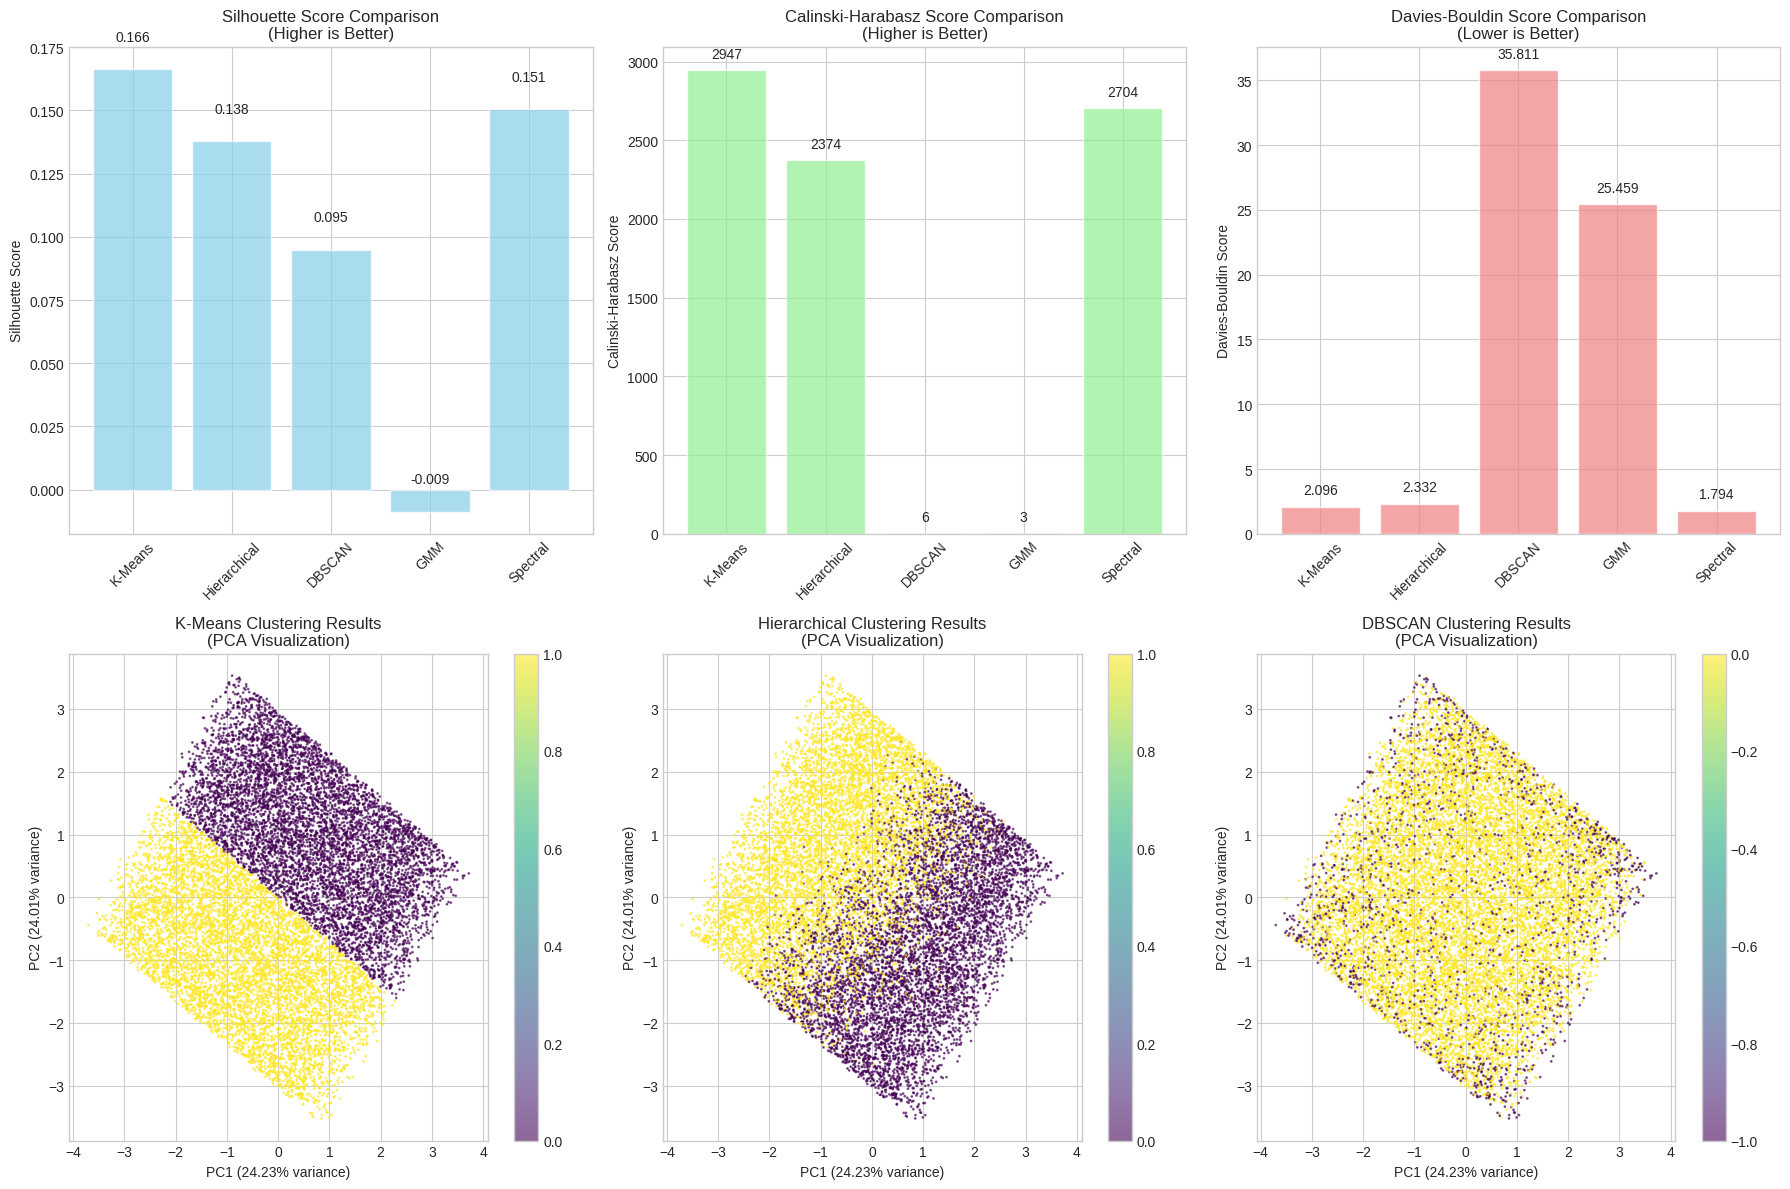

--- K-MEANS CLUSTERING ---
Distribusi Cluster:
  Cluster 0: 6707 (49.9%)
  Cluster 1: 6732 (50.1%)

Rata-rata Variabel Numerik per Cluster:
               aset        omset         laba  biaya_karyawan  tahun_berdiri  \
cluster                                                                        
0        5228466.17  25516208.93  20282690.08    2.975181e+08        2012.10   
1        5219080.00  25620638.72  20412992.00    2.956083e+08        2011.93   

         kapasitas_produksi  jumlah_pelanggan  
cluster                                        
0                    251.73            252.18  
1                    746.98            746.67  

Distribusi Variabel Kategorikal per Cluster:

jenis_usaha:
jenis_usaha  Fashion  Jasa  Kesehatan  Makanan & Minuman  Pendidikan  \
cluster                                                                
0                0.2  25.6       24.4                0.2        24.1   
1                0.2  25.0       24.1                0.3        24.2   

In [22]:
df = pd.read_csv('/kaggle/input/disco2025/dataset_edit.csv')

results, cluster_labels, best_algorithm = main_clustering_analysis(df)